In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow_datasets as tfds
import tensorflow as tf
print(tf.__version__)

2.5.0


In [4]:
# Get the data
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete9HOHDK/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete9HOHDK/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete9HOHDK/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [5]:
tokenizer = info.features['text'].encoder

In [6]:
#To remove some code error
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

In [7]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
____________________________

- The parameter passed in is the number of outputs that I desire from that layer, in this case it's 64.If I wrap that with tf.keras.layers.Bidirectional, it will make my cell state go in both directions. 

- We have our embedding and our bidirectional containing the LSTM, followed by the two dense layers. If you notice the output from the bidirectional is now a 128, even though we told our LSTM that we wanted 64, the bidirectional doubles this up to a 128. 

-  You can also stack LSTMs like any other keras layer by using code like this. But when you feed an LSTM into another one, you do have to put the return sequences equal true parameter into the first one. This ensures that the outputs of the LSTM match the desired inputs of the next one.

In [8]:
NUM_EPOCHS = 10
history1 = model1.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

history2 = model2.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 67s 145ms/step - loss: 0.5843 - accuracy: 0.6825 - val_loss: 0.5045 - val_accuracy: 0.7981
Epoch 2/10
391/391 [==============================] - 57s 144ms/step - loss: 0.3862 - accuracy: 0.8368 - val_loss: 0.5401 - val_accuracy: 0.7227
Epoch 3/10
391/391 [==============================] - 57s 144ms/step - loss: 0.2942 - accuracy: 0.8842 - val_loss: 0.3796 - val_accuracy: 0.8444
Epoch 4/10
391/391 [==============================] - 57s 145ms/step - loss: 0.2296 - accuracy: 0.9138 - val_loss: 0.4418 - val_accuracy: 0.8389
Epoch 5/10
391/391 [==============================] - 57s 144ms/step - loss: 0.3774 - accuracy: 0.8332 - val_loss: 0.5120 - val_accuracy: 0.7651
Epoch 6/10
391/391 [==============================] - 58s 147ms/step - loss: 0.4228 - accuracy: 0.8058 - val_loss: 0.5228 - val_accuracy: 0.7742
Epoch 7/10
391/391 [==============================] - 57s 145ms/step - loss: 0.3087 - accuracy: 0.8726 - val_loss: 0.4502 - val_ac


Here's the comparison of accuracies between the one layer LSTM and the two layer one over 10 epochs. There's not much of a difference except the nosedive and the validation accuracy. But notice how the training curve is smoother. I found from training networks that jaggedness can be an indication that your model needs improvement, and the single LSTM that you can see here is not the smoothest. 

- If you look at loss, over the first 10 epochs, we can see similar results. But look what happens when we increase to 50 epochs training. 
- Our one layer LSTM, while climbing in accuracy, is also prone to some pretty sharp dips. The final result might be good, but those dips makes me suspicious about the overall accuracy of the model. 

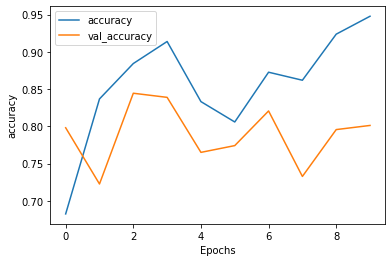

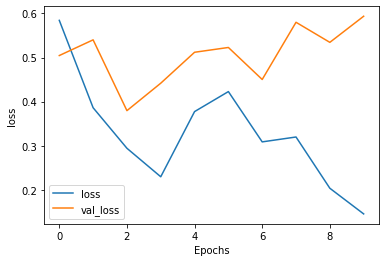

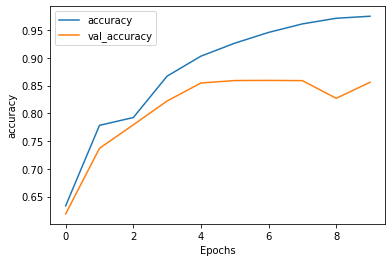

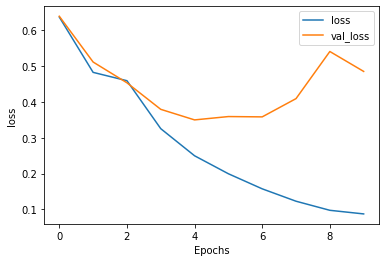

In [9]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history1, 'accuracy')
plot_graphs(history1, 'loss')


plot_graphs(history2, 'accuracy')
plot_graphs(history2, 'loss')

Our two layer one looks much smoother, and as such makes me much more confident in its results. Note also the validation accuracy. Considering it levels out at about 80 percent, it's not bad given that the training set and the test set were both 25,000 reviews. But we're using 8,000 sub-words taken only from the training set. So there would be many tokens in the test sets that would be out of vocabulary. Yet despite that, we are still at about 80 percent accuracy. Our loss results are similar with the two layer having a much smoother curve. The loss is increasing epoch by epoch. So that's worth monitoring to see if it flattens out in later epochs as would be desired. I hope this was a good introduction into how RNNs and LSTMs can help you with text classification. Their inherent sequencing is great for predicting unseen text if you want to generate some

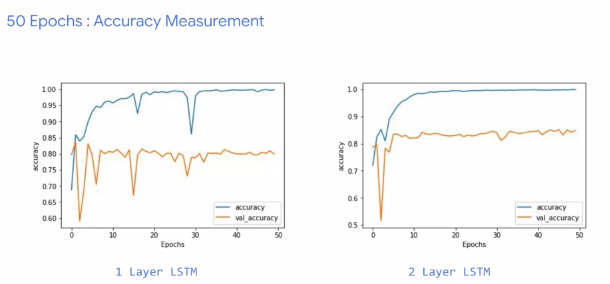



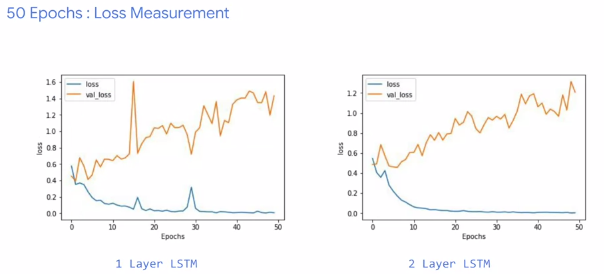